In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_csv("/content/drive/MyDrive/treated.csv")

df.shape



(176563, 88)

In [3]:
df.columns.get_loc('ProbabilityOfDefault')

38

In [4]:
# Assuming df is your DataFrame
# You want to exclude columns 38 and 41

# Get all column indices
all_columns = list(range(df.shape[1]))

# Exclude columns 38 and 41 which are probability of default and rating
exclude_columns = [38, 41]
included_columns = [col_idx for col_idx in all_columns if col_idx not in exclude_columns]

# Select columns using iloc
# X= df.iloc[:, included_columns].values
X= df.iloc[:, included_columns]
df_idx=df.iloc[:, included_columns]

### experimenting with probability of default as dependent variable

y=df.iloc[:,41]

In [5]:

 # excluded 'ProbabilityOfDefault'
numerical=['BidsManual',
 'AppliedAmount',
 'Amount',
 'Interest',
 'MonthlyPayment',
 'OccupationArea',
 'HomeOwnershipType',
 'IncomeFromPrincipalEmployer',
 'IncomeFromPension',
 'IncomeFromFamilyAllowance',
 'IncomeFromSocialWelfare',
 'IncomeFromLeavePay',
 'IncomeFromChildSupport',
 'IncomeOther',
 'IncomeTotal',
 'LiabilitiesTotal',
 'DebtToIncome',
 'FreeCash',
 'LossGivenDefault',
 'ExpectedReturn',
 'PrincipalOverdueBySchedule',
 'PrincipalPaymentsMade',
 'InterestAndPenaltyPaymentsMade',
 'PrincipalBalance',
 'InterestAndPenaltyBalance',
 'NoOfPreviousLoansBeforeLoan',
 'AmountOfPreviousLoansBeforeLoan',
 'PreviousEarlyRepaymentsCountBeforeLoan',
 'ApplicationSignedHour',
 'ApplicationSignedWeekday',
 'LanguageCode',
 'Age',
 'LoanDuration',
 'UseOfLoan',
 'ExistingLiabilities',
 'RefinanceLiabilities',
 'MonthlyPaymentDay',
 'CreditScoreEsMicroL',
 'LoanWaitTime',
 'PaymentToLoanDateDiff',
 'LoanTerm']

nloc = []

for feature in numerical:
    try:
        idx = X.columns.get_loc(feature)
        nloc.append(idx)
    except ValueError:
        print(f"Column '{feature}' not found in X columns.")


X=X.values
y=y.values

## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)


In [6]:
from sklearn.preprocessing import PowerTransformer

# Initialize PowerTransformer
power_transformer = PowerTransformer()

# Fit the transformer on training data and transform training data
X_train[:, nloc] = power_transformer.fit_transform(X_train[:, nloc])

# Transform testing data using the fitted transformer from training data
X_test[:, nloc] = power_transformer.transform(X_test[:, nloc])


In [8]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.3 MB/s eta 0:00:00


In [9]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor  # Import XGBRegressor for regression tasks

# Define the hyperparameter search space
param_space = {
    'max_depth': Integer(3, 5),
    'learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'n_estimators': Integer(100, 300),
    'gamma': Real(0, 0.2)
}

# Instantiate XGBoost regressor
xgb_reg = XGBRegressor()  # Use XGBRegressor for regression tasks

# Instantiate BayesSearchCV with Hyperband optimization
opt_reg = BayesSearchCV(
    xgb_reg,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric for regression
    cv=3,
    n_iter=100,  # Number of hyperparameter configurations to try
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'RF', 'n_initial_points': 10}
)

# Perform hyperparameter tuning for regression
opt_reg.fit(X_train, y_train)  # Assuming X_train and y_train are your regression training data

# Get best parameters and best model
best_params_reg = opt_reg.best_params_
best_model_reg = opt_reg.best_estimator_

print("Best Parameters:", best_params_reg)
print("Best Model:", best_model_reg)


Best Parameters: OrderedDict([('gamma', 0.02248818337112151), ('learning_rate', 0.09770216204275926), ('max_depth', 5), ('n_estimators', 213)])
Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02248818337112151, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09770216204275926,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=213, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [10]:
xgb=XGBRegressor(gamma= 0.02248818337112151,learning_rate=0.09770216204275926,max_depth=5, n_estimators=213)

In [11]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02248818337112151, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09770216204275926,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=213, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred=xgb.predict(X_test)

In [14]:
from joblib import dump
dump(xgb,'p2p_xgb_reg.joblib')

['p2p_xgb_reg.joblib']

In [19]:
# prompt: perform r2_score,mae,mse,rmse,mape

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error,mean_absolute_percentage_error

# Calculate and print R2 score
r2_score_value = r2_score(y_test, y_pred)
print("R2 Score:", r2_score_value)

# Calculate and print Mean Absolute Error (MAE)
mae_value = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae_value)

# Calculate and print Mean Squared Error (MSE)
mse_value = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_value)

# Calculate and print Root Mean Squared Error (RMSE)
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

# Calculate and print Mean Absolute Percentage Error (MAPE)
mape_value = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape_value)


R2 Score: 0.9716700504929743
Mean Absolute Error (MAE): 0.20035084911737416
Mean Squared Error (MSE): 0.09104020455871632
Root Mean Squared Error (RMSE): 0.3017286936284256
Mean Absolute Percentage Error (MAPE): 85323205333570.1


In [20]:
# prompt: do explained variance

from sklearn.metrics import explained_variance_score

explained_variance = explained_variance_score(y_test, y_pred)
print("Explained Variance:", explained_variance)


Explained Variance: 0.9716702807882793


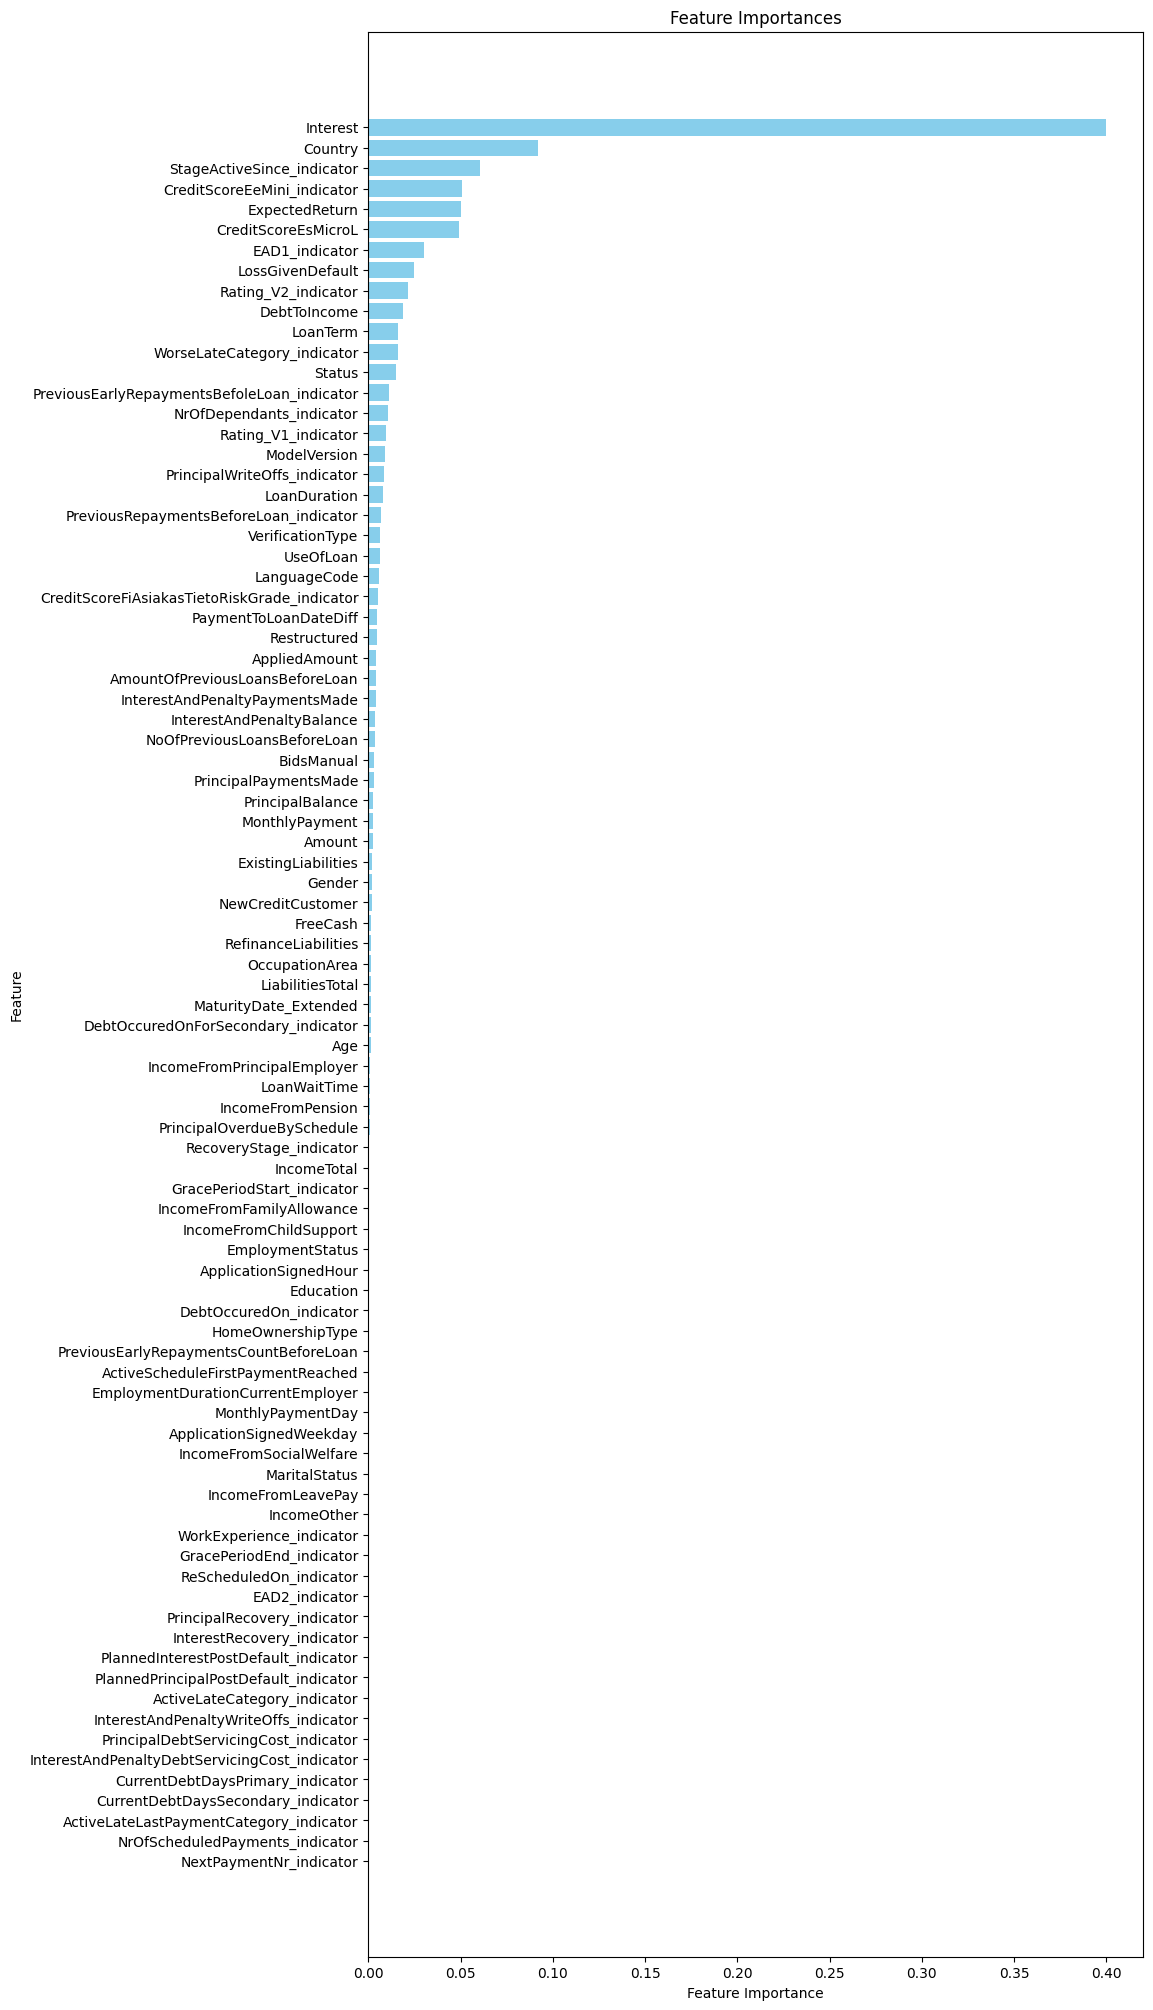

In [36]:
import matplotlib.pyplot as plt

# Compute feature importances
feature_importances = xgb.feature_importances_

# Create a dictionary to store feature importances
feature_importance_dict = {}

# Loop through feature names and importances and store them in the dictionary
for feature_name, importance in zip(df_idx.columns, feature_importances):
    feature_importance_dict[feature_name] = importance

# Sort the feature importance dictionary by importance values in descending order
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Extract feature names and importances from the sorted dictionary
feature_names = list(sorted_feature_importance_dict.keys())
importances = list(sorted_feature_importance_dict.values())

# Create a horizontal bar chart
plt.figure(figsize=(10, 25))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display features with highest importance on top
plt.show()

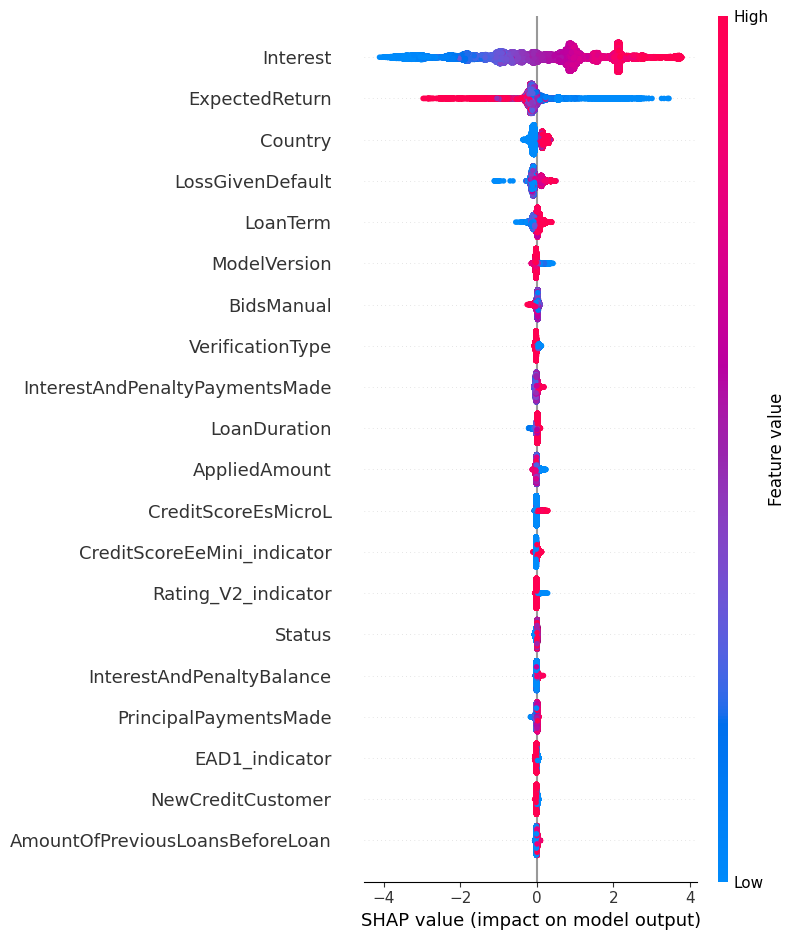

In [26]:
import shap

explainer = shap.Explainer(xgb, feature_names=df_idx.columns)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df_idx.columns)

In [29]:
# !pip install lime
import lime
from lime import lime_tabular

In [31]:
explainer=lime.lime_tabular.LimeTabularExplainer(X_train,mode="regression",feature_names=df_idx.columns,class_names=["Prediction"])

In [32]:
instance_idx=0
explanation=explainer.explain_instance(X_test[instance_idx],xgb.predict,num_features=len(df_idx.columns))

In [33]:
import matplotlib.pyplot as plt
explanation.show_in_notebook(show_table=True)
plt.savefig('p2p_xgb_reg_lime.png',bbox_inches='tight')

<Figure size 640x480 with 0 Axes>